In [35]:
import mplfinance as mpf
import matplotlib.dates as mpl_dates
import math
from IPython.display import clear_output
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.mode.chained_assignment = None

In [15]:
nifty5 = pd.read_csv('Cleaned_Nifty50_5min.csv')
nifty5['EMA']=nifty5['Close'].ewm(span=5, adjust=False).mean()

In [16]:
nifty5

,Date,Open,High,Low,Close,Time,EMA
0,09-01-2015,8285.45,8301.30,8285.45,8301.20,09:15,8301.200000
1,09-01-2015,8300.50,8303.00,8293.25,8301.00,09:20,8301.133333
2,09-01-2015,8301.65,8302.55,8286.80,8294.15,09:25,8298.805556
3,09-01-2015,8294.10,8295.75,8280.65,8288.50,09:30,8295.370370
4,09-01-2015,8289.10,8290.45,8278.00,8283.45,09:35,8291.396914
...,...,...,...,...,...,...,...
114220,25-03-2021,14338.40,14349.70,14319.05,14319.05,15:05,14373.149535
114221,25-03-2021,14319.15,14320.25,14274.15,14299.00,15:10,14348.433023
114222,25-03-2021,14298.90,14315.80,14287.55,14299.75,15:15,14332.205349
114223,25-03-2021,14299.45,14317.40,14295.75,14314.95,15:20,14326.453566


In [17]:
c1 = pd.DataFrame(columns=['Date', 'Number of trades','Average time'])
c1['Date'] = nifty5['Date'].unique()
c1['Number of trades']=0
c1['Average time']=0

In [120]:
#variable a is for offsetting the backtest from some date.
c=0
profp=[]
lossp=[]
c1['Number of trades']=0
c1['Average time']=0
th=[]
# def buy(i,j,tgt,sl):
#     global c,profp,lossp
#     c=c+1
#     byp=nifty5['Close'][(i)*75+j]
#     d=nifty5['Date'][(i)*75+j]
#     for k in range(j,70):
#         if nifty5['Close'][(i)*75+k]<sl:
#             #print('Date: {} Target: ₹{:.2f}  Stoploss: ₹{:.2f} Long Stoploss hit!'.format(d,tgt,sl))
#             lossp.append(100*(byp-sl)/byp)
#             return sl
#         if nifty5['High'][(i)*75+k]>tgt:
#             #print('Date: {} Target: ₹{:.2f}  Stoploss: ₹{:.2f} Long Target hit!'.format(d,tgt,sl))
#             profp.append(100*(tgt-byp)/byp)
#             return tgt
#     #print('Date: {} Target: ₹{:.2f}  Stoploss: ₹{:.2f}  Time out!'.format(d,tgt,sl))
#     return nifty5['Low'][(i)*75+k]

def sell(i,j,tgt,sl):
    global c,profp,lossp,th
    slp=nifty5['Close'][i*75+j]
    d=nifty5['Date'][(i)*75+j]
    k=j
    for k in range(j,70):
        if nifty5['Low'][(i)*75+k]<tgt:
            #print('Date: {} Target: ₹{:.2f}  Stoploss: ₹{:.2f} Short Target hit!'.format(d,tgt,sl))
            profp.append(100*(slp-tgt)/slp)
            th.append(k-j)
            return k, tgt
        if nifty5['Close'][(i)*75+k]>sl:
            #print('Date: {} Target: ₹{:.2f}  Stoploss: ₹{:.2f} Short Stoploss hit!'.format(d,tgt,sl))
            lossp.append(100*(sl-slp)/slp)
            th.append(k-j)
            return k, sl
    #print('Date: {} Target: ₹{:.2f}  Stoploss: ₹{:.2f}  Time out!'.format(d,tgt,sl))
    th.append(k-j)
    return k, nifty5['Close'][i*75+k]

proftolossratio=1.5
daysconsidered=50 #offset to start for some given date
a=nifty5.Date.nunique()-daysconsidered
ini=100000
balance=ini
minbalance=ini
maxbalance=0
bal=[]
tgt1=0
sl1=0
flag=0
profit=0
loss=0
leverage=5
for i in range(a,nifty5.Date.nunique()):
    flag=0
    profit=0
    n=int(balance/nifty5['Open'][i*75])
    k1=0
    for j in range(1,nifty5.Time.nunique()):
        if j<=k1:
            continue
        if nifty5['Close'][i*75+j-1]>nifty5['EMA'][i*75+j-1]:
            if nifty5['Close'][i*75+j]<nifty5['Open'][i*75+j]:
                if nifty5['Close'][i*75+j]<nifty5['EMA'][i*75+j]:
                    stpls=nifty5['High'][i*75+j-1]-nifty5['Close'][i*75+j]
                    trgt=nifty5['Close'][i*75+j]-stpls*proftolossratio
                    k1, byp=sell(i,j,trgt,nifty5['High'][i*75+j-1])       
                    profit=nifty5['Close'][i*75+j]-byp
                    c1.at[i, 'Number of trades']+=1
    th=np.array(th)
    c1.at[i, 'Average time'] = th.mean()*5
    th=[]
    balance=balance+leverage*n*profit
    bal.append(balance)
    if balance<0:
        print("Total Loss")
        break
    if balance>=maxbalance:
        maxbalance=balance
    if balance<minbalance:
        minbalance=balance

res=(balance-ini)/ini
print('Total count of trade days :',len(c1[c1['Number of trades']!=0]),'out of ',nifty5.Date.nunique()-a,' days')
print('Average number of trades per day: {:.2f}'.format(c1['Number of trades'].mean()))
print('Average time held per trade: {:.2f} minutes \n'.format(c1['Average time'].mean()))
if balance>=ini:
    print("Final Balance is ₹{:.2f} with return of {:.2f}%".format(balance,res*100))
else:
    print("Final Balance is ₹{:.2f} with a loss of {:.2f} at {:.2f}%".format(balance,ini-balance,100*(ini-balance)/ini))
print("Minimum Balance was ₹{:.2f} and Maximum Balance was ₹{:.2f}".format(minbalance,maxbalance))
print("Nifty Return for the same time period is {:.2f}%".format(100*(nifty5['Close'][(i)*75+j]-nifty5['Close'][a*75+j])/nifty5['Close'][a*75+j]))
bal = [x * (nifty5['Open'][(a+1)*75]/100000) for x in bal]
profp=np.array(profp)
lossp=np.array(lossp)
pn=len(profp)
ln=len(lossp)
pm=profp.mean()
lm=lossp.mean()
print('\nNumber of Profits: {} Losses: {} \nAverage Profit: {:.2f}% Average Loss: {:.2f}%'.format(pn,ln,pm,lm))
print('Win ratio of: {:.2f}% and net profit per trade of {:.2f}%'.format(100*pn/(ln+pn),(pm*pn-lm*ln)/(pn+ln)))
print('\nRESULTS WITH LEVERAGE OF 5x')
profp=profp*leverage
lossp=lossp*leverage
pm=profp.mean()
lm=lossp.mean()
print('Number of Profits: {} Losses: {} \nAverage Profit: {:.2f}% Average Loss: {:.2f}%'.format(pn,ln,pm,lm))
print('Win ratio of: {:.2f}% and net profit per trade of {:.2f}%'.format(100*pn/(ln+pn),(pm*pn-lm*ln)/(pn+ln)))

Total count of trade days : 50 out of  50  days
Average number of trades per day: 0.18
Average time held per trade: 1.17 minutes 

Final Balance is ₹117152.25 with return of 17.15%
Minimum Balance was ₹100000.00 and Maximum Balance was ₹117152.25
Nifty Return for the same time period is -1.57%

Number of Profits: 130 Losses: 106 
Average Profit: 0.23% Average Loss: 0.17%
Win ratio of: 55.08% and net profit per trade of 0.05%

RESULTS WITH LEVERAGE OF 5x
Number of Profits: 130 Losses: 106 
Average Profit: 1.14% Average Loss: 0.87%
Win ratio of: 55.08% and net profit per trade of 0.23%


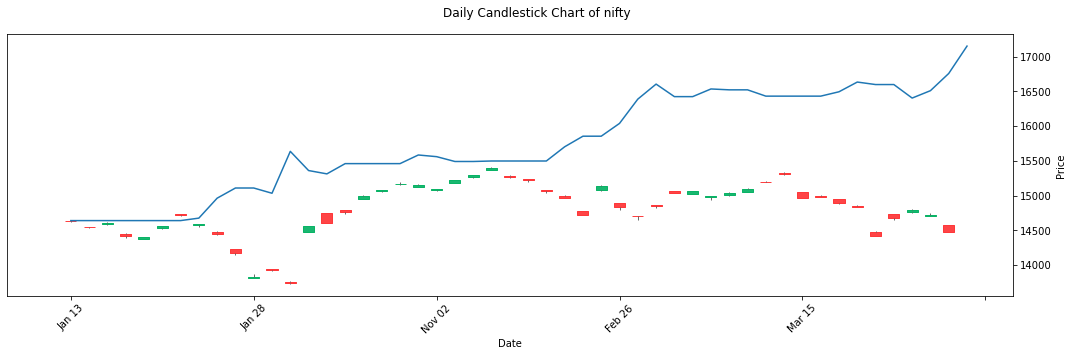

In [121]:
f=75
plotnifty=nifty5.iloc[a*f::f, :]
plotnifty.index = pd.to_datetime(plotnifty.Date)
plotnifty.drop('Date',axis=1,inplace=True)
plotnifty=plotnifty.iloc[1:,:]
#Creating Subplots
fig, ax = plt.subplots(figsize=(15,5))
mpf.plot(plotnifty[:], type='candle', style='yahoo',ax=ax,warn_too_much_data=2000)
#plt.plot(plotnifty['EMA'].values)
plt.plot(bal[:])
# plt.plot(bnifty[a:]['Date'], bal,'k')
# plt.plot(bnifty[a:]['Date'], bnifty[a:]['sma'])
# Setting labels & titles
ax.set_xlabel('Date')
ax.set_ylabel('Price')
fig.suptitle('Daily Candlestick Chart of nifty')
fig.tight_layout()